INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-03-01 07:00:00 and 2019-06-18 19:00:00


MAPE = 74.06360942428275%
SMAPE = 16.596423002751425%


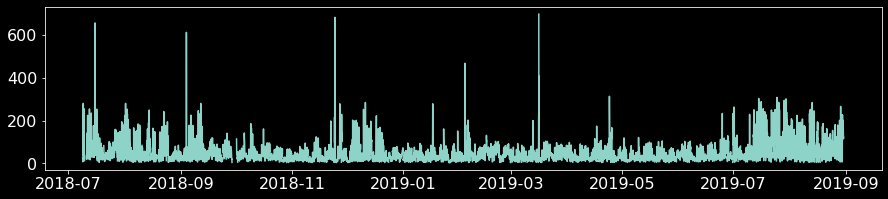

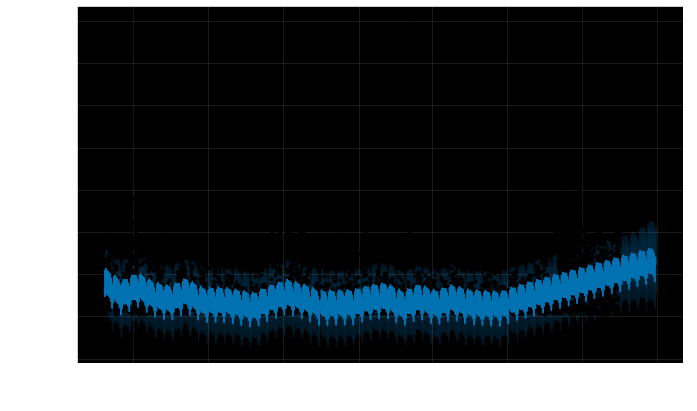

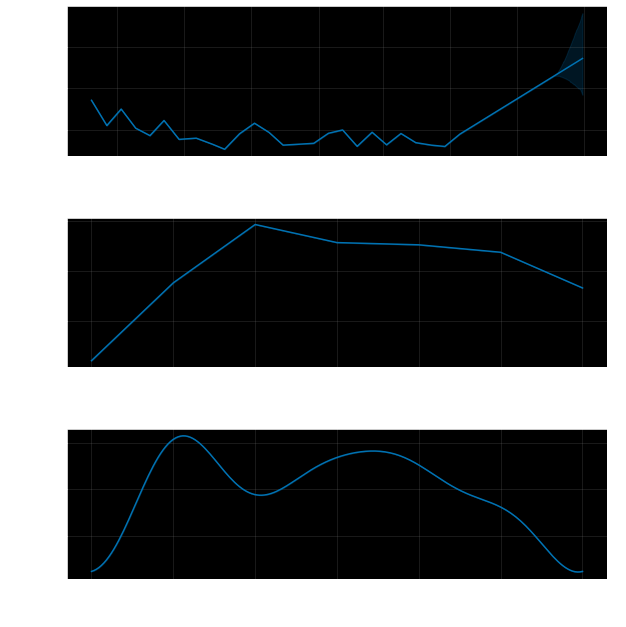

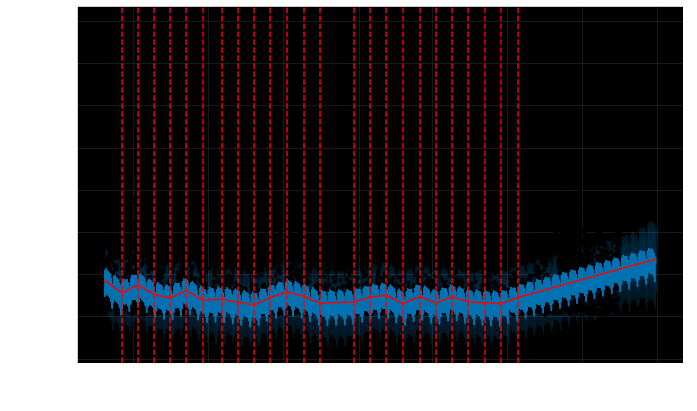

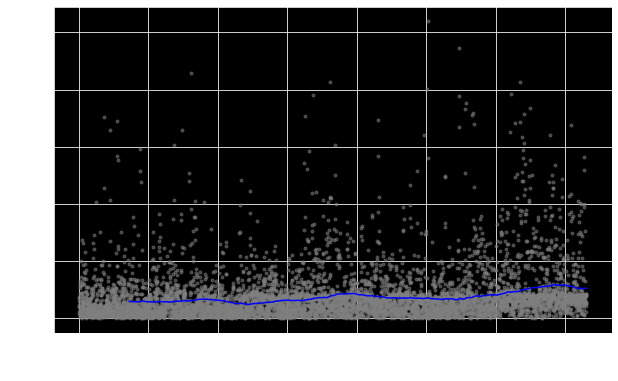

In [118]:
# load JSON
import json
import pandas as pd
import numpy as np

n_samples = 10000
i = n_samples
n_prd = 720
n_offset = 0

# hourly data 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
data = data.sort_values(by=['ds'])
data['just_date'] = data['ds'].dt.date
temp = data.iloc[-1,:]
firstDate = temp['just_date']

t_start = len(data) - n_samples - n_prd - n_offset
df_h = data[t_start:(t_start+n_samples)]

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
plt.figure(figsize=(15,3))
plt.plot(df_h['ds'],df_h['y'])

df = df_h # select daily or hourly daya

from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=n_prd, freq='H')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# PROPHET validation
from fbprophet.diagnostics import cross_validation
horInt = int(365*i/50000)
df_cv = cross_validation(m, horizon = str(horInt) + ' days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

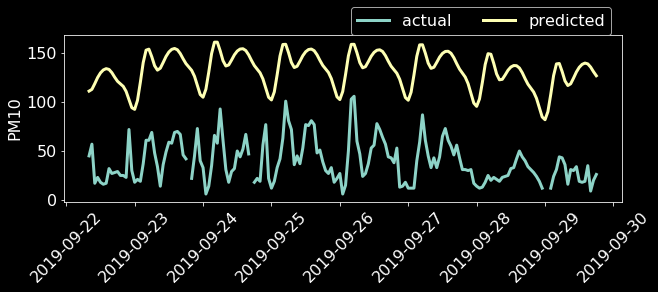

In [119]:
import matplotlib

ind1 = int(-n_prd/4)
ind2 = -1

plt.style.use('dark_background')
font = {'size': 16,             # font setting
       'weight':'normal'}       # font setting
matplotlib.rc('font', **font)   # font setting

plt.figure(figsize=(10,4))
plt.plot(data.ds[ind1-n_offset:ind2-n_offset],data.y[ind1-n_offset:ind2-n_offset],linewidth=3)
plt.plot(forecast.ds[ind1:ind2],forecast.yhat[ind1:ind2],linewidth=3)
#plt.plot(forecast.ds[ind1:ind2],forecast.yhat_upper[ind1:ind2],color='gray')
#plt.plot(forecast.ds[ind1:ind2],forecast.yhat_lower[ind1:ind2],color='gray')
plt.legend(('actual','predicted'),bbox_to_anchor=(0.5,0.95),ncol=2)
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 45)
plt.ylabel('PM10')
plt.gcf().subplots_adjust(bottom=0.3)
plt.savefig('detailValidate_' + str(n_offset) + '.png',transparent=True)